# RL and Advanced DL: Домашнее задание 2

## Часть первая: крестики-нолики при помощи Q-обучения


1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

### Tic Tac Toe environment из семинара

In [2]:
EMPTY = 0
CROSSES_TURN = 1
NOUGHTS_TURN = -1

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        if clone is not None:
            self.n_rows = clone.n_rows
            self.n_cols = clone.n_cols
            self.n_win = clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = "".join(
                [f"{x + 1}"
                 for x in self.board.reshape(self.n_rows * self.n_cols)]
            )
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p
                                        for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p
                                        for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print("----" * (self.n_cols) + "-")
            out = "| "
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = "x"
                if self.board[i, j] == -1:
                    token = "o"
                if self.board[i, j] == 0:
                    token = " "
                out += token + " | "
            print(out)
        print("----" * (self.n_cols) + "-")

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

### Стратегии: Random и EpsGreedy

In [4]:
def get_pi(pi_crosses, pi_noughts, turn):
    return pi_crosses if turn == CROSSES_TURN else pi_noughts


class BasePolicy:
    def __init__(self, turn):
        self.turn = turn
    
    def check_win(self, reward):
        if reward == CROSSES_TURN:
            return 1 if self.turn == CROSSES_TURN else -1
        if reward == NOUGHTS_TURN:
            return 1 if self.turn == NOUGHTS_TURN else -1
        return 0 # draw

    
class RandomPolicy(BasePolicy):
    
    def select_action(self, state, eps):
        _, allowed_actions, _ = state
        action_idx = np.random.randint(len(allowed_actions))
        return action_idx

    
class EpsGreedyPolicy(BasePolicy):
    def __init__(self, turn):
        self.Q = {}
        self.turn = turn

    def select_action(self, state, eps):
        board_hash, allowed_actions, _ = state
        
        if board_hash not in self.Q:
            self.Q[board_hash] = np.zeros(len(allowed_actions))
        
        if random.random() >= eps:
            return np.argmax(self.Q[board_hash])
        else:
            return np.random.randint(len(allowed_actions))

### Валидация обученной стратегии: проверяем winrate pi_lhs относительно pi_rhs

In [5]:
def run_eval_episode(env, policies, eps):
    
    env.reset()
    state = env.getState()
    _, allowed_actions, turn = state

    done = False
    while not done:
        action_idx = policies[turn].select_action(state, eps)
        action = allowed_actions[action_idx]
        state, reward, done, _ = env.step(action)
        _, allowed_actions, turn = state

    return reward

In [6]:
def eval_policy(env, pi_eval, pi_other, episodes, verbose=False):
    """
    eval pi_eval vs pi_other,
    returns winrate, looserate, drawrate
    """
    policies = dict()
    policies[CROSSES_TURN] = pi_eval  if pi_eval.turn == CROSSES_TURN  else pi_other
    policies[NOUGHTS_TURN] = pi_other if pi_other.turn == NOUGHTS_TURN else pi_eval
    assert policies[CROSSES_TURN].turn == CROSSES_TURN
    assert policies[NOUGHTS_TURN].turn == NOUGHTS_TURN
    
    wins = 0
    looses = 0
    draws = 0

    for _ in tqdm(range(episodes), disable = not verbose):
        reward = run_eval_episode(env, policies, eps=0)
        is_win = pi_eval.check_win(reward)
        wins += int(is_win == 1)
        looses += int(is_win == -1)
        draws += int(is_win == 0)

    return wins / episodes, looses / episodes, draws / episodes

In [7]:
def plot_history(history, player, fontsize: int = 16, figsize: tuple = (12, 6)):
    plt.figure(figsize=figsize)
    plt.title(f'Average rates during training: {player}', fontsize=fontsize)
    plt.xlabel('Step', fontsize=fontsize)
    plt.ylabel('Average rate', fontsize=fontsize)
    history = history[player]
    x = [s for s, _, _, _ in history]
    wr = [s for _, s, _, _ in history]
    lr = [s for _, _, s, _ in history]
    dr = [s for _, _, _, s in history]
    plt.plot(x, wr, label="winrate")
    plt.plot(x, lr, label="looserate")
    plt.plot(x, dr, label="drawrate")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
# sanity checks для random policy

ENV = TicTacToe(n_rows=3, n_cols=3, n_win=3)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), RandomPolicy(turn=NOUGHTS_TURN), episodes=1000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN),  RandomPolicy(turn=CROSSES_TURN), episodes=1000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

ENV = TicTacToe(n_rows=4, n_cols=4, n_win=4)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), RandomPolicy(turn=NOUGHTS_TURN), episodes=1000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN),  RandomPolicy(turn=CROSSES_TURN), episodes=1000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

ENV = TicTacToe(n_rows=5, n_cols=5, n_win=5)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), RandomPolicy(turn=NOUGHTS_TURN), episodes=1000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN),  RandomPolicy(turn=CROSSES_TURN), episodes=1000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

CrossRandomPolicy on 3x3: winrate=0.573, looserate=0.314, drawrate=0.113
NoughtsRandomPolicy on 3x3: winrate=0.275, looserate=0.589, drawrate=0.136

CrossRandomPolicy on 4x4: winrate=0.296, looserate=0.281, drawrate=0.423
NoughtsRandomPolicy on 4x4: winrate=0.266, looserate=0.317, drawrate=0.417

CrossRandomPolicy on 5x5: winrate=0.26, looserate=0.16, drawrate=0.58
NoughtsRandomPolicy on 5x5: winrate=0.147, looserate=0.278, drawrate=0.575



### Обучаем EpsGreedy стратегию с помощью Q-learning

In [9]:
def q_learning_episode(env, policies, alpha, gamma, eps):

    env.reset()
    state = env.getState()
    board_hash, allowed_actions, turn = state
    prev_board_hash, prev_action_idx = None, None

    done = False
    while not done:
        
        # update curr turn policy
        pi = policies[turn]
        action_idx = pi.select_action(state, eps)
        action = allowed_actions[action_idx]
        state, reward, done, _ = env.step(action)
        if reward == turn:
            pi.Q[board_hash][action_idx] = abs(reward)
        policies[turn] = pi

        # update opposite policy
        next_board_hash, next_allowed_actions, next_turn = state
        pi = policies[next_turn]
        if prev_board_hash is not None:
            gamma_term = gamma * np.max(pi.Q[next_board_hash]) if next_board_hash in pi.Q else 0
            pi.Q[prev_board_hash][prev_action_idx] += alpha * (
                -reward + gamma_term - pi.Q[prev_board_hash][prev_action_idx]
            )
        policies[next_turn] = pi

        prev_board_hash, prev_action_idx = board_hash, action_idx
        board_hash, allowed_actions, turn = state

    return policies

In [10]:
def q_learning(env, pi_crosses, pi_noughts, episodes = 10000,
               eps_init = 0.9, eps_final = 0.01,
               alpha = 0.01, gamma = 0.08):
    
    eval_every = int(episodes * 0.05)
    eval_episodes = int(episodes * 0.10)
    eps_decay = int(episodes * 0.8)
    
    policies = dict()
    policies[CROSSES_TURN] = pi_crosses
    policies[NOUGHTS_TURN] = pi_noughts
    assert pi_crosses.turn == CROSSES_TURN
    assert pi_noughts.turn == NOUGHTS_TURN
    
    hist = defaultdict(list)
    for epoch in tqdm(range(episodes)):
        
        eps = eps_init + (eps_final - eps_init) * epoch / eps_decay
        policies = q_learning_episode(env, policies, alpha, gamma, eps)

        if (epoch + 1) % eval_every == 0:
            step = epoch + 1
            wr, lr, dr = eval_policy(env, policies[CROSSES_TURN], RandomPolicy(NOUGHTS_TURN), eval_episodes)
            hist['crosses'].append((step, wr, lr, dr))
            wr, lr, dr = eval_policy(env, policies[NOUGHTS_TURN], RandomPolicy(CROSSES_TURN), eval_episodes)
            hist['noughts'].append((step, wr, lr, dr))

    return hist

100%|████████████████████████████████████| 20000/20000 [00:33<00:00, 598.38it/s]


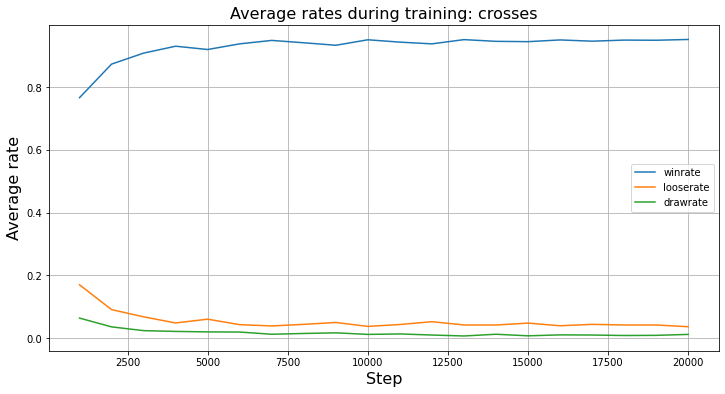

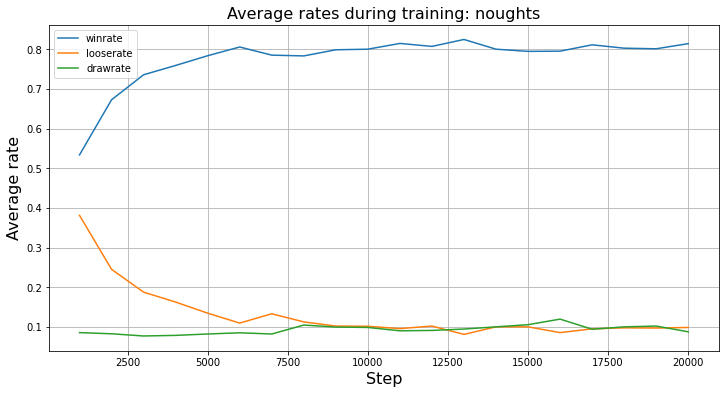

In [11]:
hist = q_learning(
    TicTacToe(n_rows=3, n_cols=3, n_win=3),
    pi_crosses=EpsGreedyPolicy(turn=CROSSES_TURN),
    pi_noughts=EpsGreedyPolicy(turn=NOUGHTS_TURN),
    episodes=20000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')

100%|██████████████████████████████████| 100000/100000 [05:51<00:00, 284.35it/s]


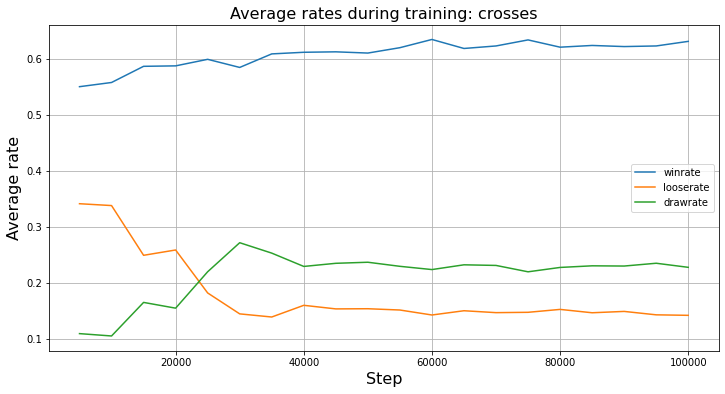

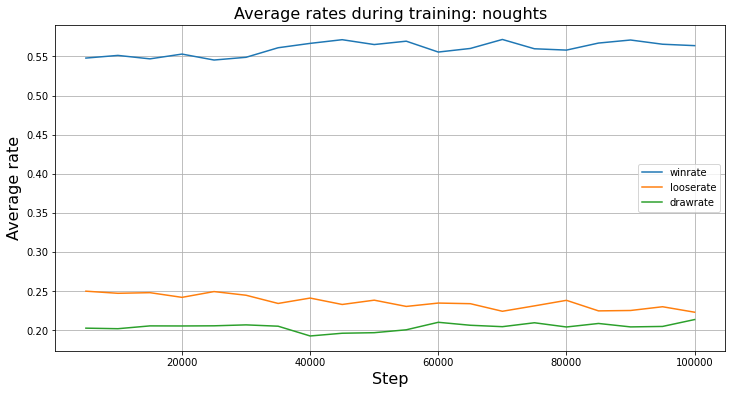

In [14]:
hist = q_learning(
    TicTacToe(n_rows=4, n_cols=4, n_win=4),
    pi_crosses=EpsGreedyPolicy(turn=CROSSES_TURN),
    pi_noughts=EpsGreedyPolicy(turn=NOUGHTS_TURN),
    episodes=100000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')

100%|████████████████████████████████| 500000/500000 [1:03:07<00:00, 132.03it/s]


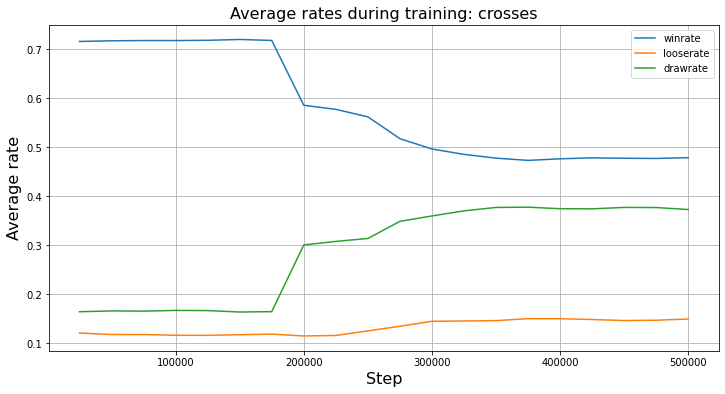

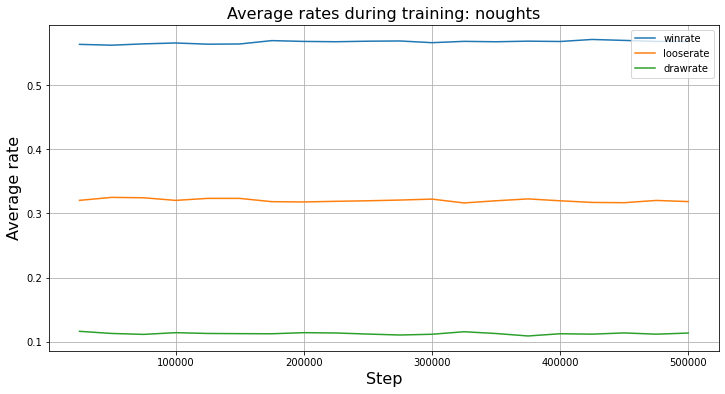

In [16]:
hist = q_learning(
    TicTacToe(n_rows=5, n_cols=5, n_win=5),
    pi_crosses=EpsGreedyPolicy(turn=CROSSES_TURN),
    pi_noughts=EpsGreedyPolicy(turn=NOUGHTS_TURN),
    episodes=500000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')